## 1. Combined Cycle Power Plant Data Set

### (a) Download Data

Package imports

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import neighbors
from sklearn import preprocessing
import math

Get the Cycle Power Plant Data Set

In [2]:
dataframe = pd.read_excel('../data/CCPP/Folds5x2_pp.xlsx',sheet_name=1,names=['AT','V','AP','RH','PE'])

In [3]:
dataframe

,AT,V,AP,RH,PE
0,9.59,38.56,1017.01,60.10,481.30
1,12.04,42.34,1019.72,94.67,465.36
2,13.87,45.08,1024.42,81.69,465.48
3,13.72,54.30,1017.89,79.08,467.05
4,15.14,49.64,1023.78,75.00,463.58
...,...,...,...,...,...
9563,17.10,49.69,1005.53,81.82,457.32
9564,24.73,65.34,1015.42,52.80,446.92
9565,30.44,56.24,1005.19,56.24,429.34
9566,23.00,66.05,1020.61,80.29,421.57


### (b) Exploring the data

#### i. rows and columns

In [4]:
print(f'The number of rows in the dataset is {len(dataframe.index)}')
print(f'The number of columns in the dataset is {len(dataframe.axes[1])}')

The number of rows in the dataset is 9568
The number of columns in the dataset is 5


1. The rows represent the data points collected over 6 years at the CCPP when it was operating at full capacity to predict the net hourly electrical output at the power plant.
2. The columns represent the features of each data, namely: ambient variables Temperature(AT),Ambient Pressure(AP),Relative Humidity(RH) and Exhaust Vacuum(V)

#### ii. pairwise scatterplots of all the varianbles

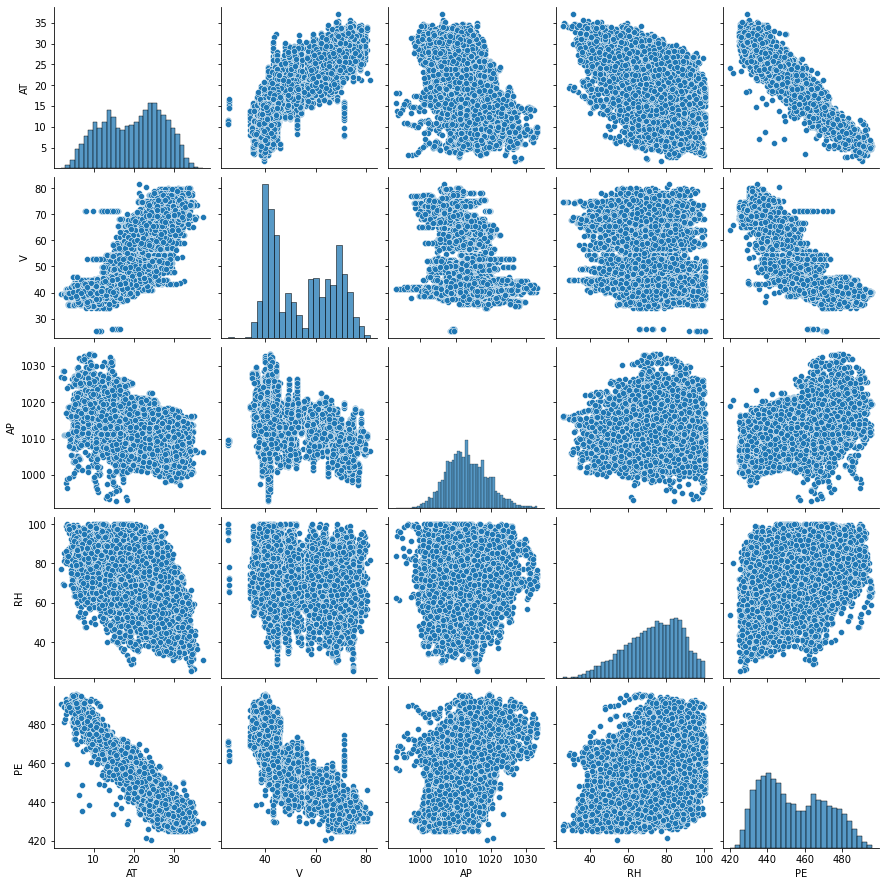

In [5]:
pp = seaborn.pairplot(dataframe,kind="scatter")

#### Scatter plot Inference:
1. Negative correlation and almost linear relationship between AT and PE.
2. Negative correlation and moderate linear relationship between PE and V.
3. Positive correlation between AT and V(As V increases AT decreases and vice versa).

#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

In [6]:
def calculate_mean(column):
    csum = 0
    for data in column:
        csum += data
    return csum/len(column)

def calculate_median(column):
    column.sort()
    return column[int(len(column)/2)]

def calculate_range(column):
    return max(column)-min(column)

def calculate_quartiles(column):
    column.sort()
    n = len(column)+1
    first_quartile = int(n*(1/4))
    second_quartile = int(n*(1/2))
    third_quartile = int(n*(3/4))
    return (column[first_quartile],column[second_quartile],column[third_quartile])

In [7]:
mean = []
median = []
crange = []
fquart = []
squart = []
tquart = []
iqr = []
for cname in ['AT','V','AP','RH','PE']:
    mean.append(calculate_mean(list(dataframe[cname])))
    median.append(calculate_median(list(dataframe[cname])))
    crange.append(calculate_range(list(dataframe[cname])))
    q1,q2,q3 = calculate_quartiles(list(dataframe[cname]))
    fquart.append(q1)
    squart.append(q2)
    tquart.append(q3)
    iqr.append(q3-q1)
data = [mean,median,crange,fquart,squart,tquart,iqr]

In [8]:
summary = pd.DataFrame(data,columns=['AT','V','AP','RH','PE'],index=['MEAN','MEDIAN','RANGE','FIRST QUARTILE',
                                                                     'SECOND QUARTILE','THIRD QUARTILE','INTER QUARTILE RANGE'])

In [9]:
summary

,AT,V,AP,RH,PE
MEAN,19.651231,54.305804,1013.259078,73.308978,454.365009
MEDIAN,20.350000,52.080000,1012.940000,74.980000,451.580000
RANGE,35.300000,56.200000,40.410000,74.600000,75.500000
FIRST QUARTILE,13.510000,41.740000,1009.100000,63.330000,439.750000
SECOND QUARTILE,20.350000,52.080000,1012.940000,74.980000,451.580000
THIRD QUARTILE,25.720000,66.540000,1017.260000,84.830000,468.430000
INTER QUARTILE RANGE,12.210000,24.800000,8.160000,21.500000,28.680000


### (c) Simple Linear Regression

In [10]:
def find_outliers(df,cname):
    q1,q2,q3 = calculate_quartiles(list(df))
    iqr = q3-q1
    lower_limit = q1-(1.5*iqr)
    upper_limit = q3+(1.5*iqr)
    outliers = df[((df<(q1-1.5*iqr)) | (df>(q3+1.5*iqr)))]
    res = []
    for ind in dataframe.index:
        if dataframe[cname][ind] in list(outliers):
            res.append(dataframe['PE'][ind])
    res_df = pd.DataFrame(res,columns=['PE'])
    return (outliers,res_df)

AT
--
Linear Equation: PE = -2.1713199585177936 * AT + 497.03411989276674
r-squared: 0.8989475964148236
Inference: 89.89475964148235% of the variation in PE can be explained by AT
Scatter plot:


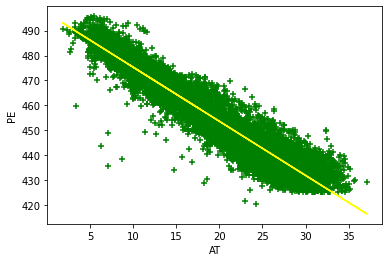

V
--
Linear Equation: PE = -1.1681351265557125 * V + 517.801526308386
r-squared: 0.7565177870683978
Inference: 75.65177870683978% of the variation in PE can be explained by V
Scatter plot:


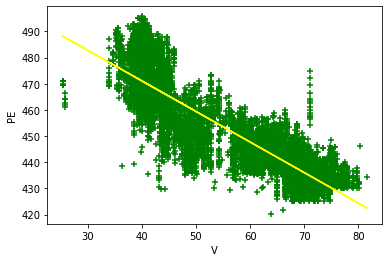

AP
--
Linear Equation: PE = 1.4898716733991124 * AP + -1055.2609889844382
r-squared: 0.2687686564110674
Inference: 26.87686564110674% of the variation in PE can be explained by AP
Scatter plot:


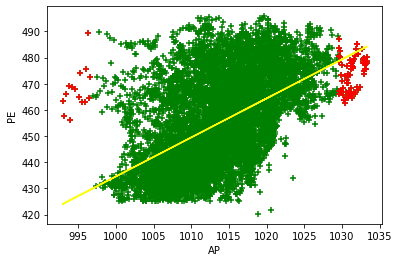

AP contains outliers 

RH
--
Linear Equation: PE = 0.4556501022629803 * RH + 420.96176615548393
r-squared: 0.151939440231176
Inference: 15.1939440231176% of the variation in PE can be explained by RH
Scatter plot:


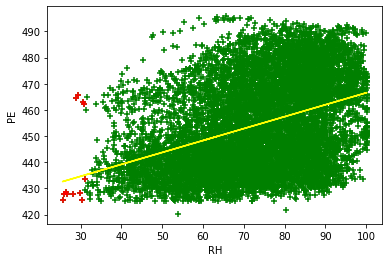

RH contains outliers 



In [11]:
simple_coef = []
result = dataframe['PE']
for cname in ['AT','V','AP','RH']:
    print(cname)
    print('--')
    predictor = dataframe[[cname]]
    lmodel = linear_model.LinearRegression()
    lmodel.fit(predictor,result)
    print(f'Linear Equation: PE = {lmodel.coef_[0]} * {cname} + {lmodel.intercept_}')
    simple_coef.append(lmodel.coef_[0])
    score = lmodel.score(predictor,result)
    print(f'r-squared: {score}')
    print(f'Inference: {score*100}% of the variation in PE can be explained by {cname}')
    outlier,res = find_outliers(dataframe[cname],cname)
    print('Scatter plot:')
    plt.scatter(x=predictor,y=result,color="green",marker='+')
    plt.scatter(x=outlier,y=res,color="red",marker="+")
    plt.plot(dataframe[cname],lmodel.predict(predictor),color="yellow")
    plt.xlabel(cname)
    plt.ylabel('PE')
    plt.show()
    if len(outlier) > 0:
        print(f'{cname} contains outliers \n')

<font color="red">From the above models we can say that all models indicate statistically significant influence with PE (p less than 0.05). Also, AT is having the highest inluence on PE</font>

### (d) Multiple Regression

In [12]:
x = dataframe.drop('PE',axis="columns")
m_model = linear_model.LinearRegression()
m_model.fit(x,dataframe['PE'])

print("Multi-variable linear regression equation:")
print("-----------------------------------------")
print(f'PE = {m_model.coef_[0]:0.2f} * AT + {m_model.coef_[1]:0.2f} * V + {m_model.coef_[2]:0.2f} * AP + {m_model.coef_[3]:0.2f} * RH + {m_model.intercept_:0.2f}\n')
print(f'Regression Model Score: {m_model.score(x,dataframe["PE"])}\n')

multi_coef = list(m_model.coef_)

x = sm.add_constant(x, prepend=False)
omodel = sm.OLS(dataframe['PE'], x)
ores = omodel.fit()
print(ores.summary())

print("p-values:", ores.pvalues)

Multi-variable linear regression equation:
-----------------------------------------
PE = -1.98 * AT + -0.23 * V + 0.06 * AP + -0.16 * RH + 454.61

Regression Model Score: 0.9286960898122536

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:50:42   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 c

<font color="red">Since the p-values of all the predictors are less than 0.05, we can REJECT null hypothesis</font>

### (e) 1c Compare to 1d

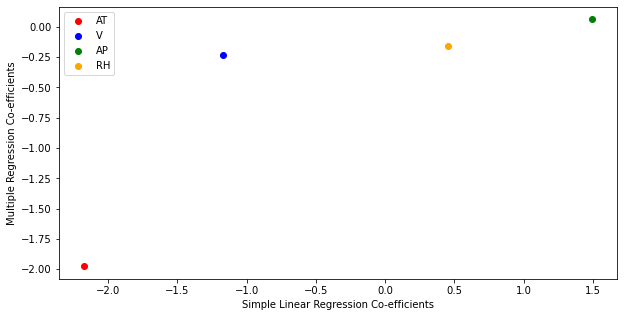

In [13]:
colors=["red","blue","green","orange"]
labels=['AT','V','AP','RH']
fig, axes = plt.subplots(figsize=(10, 5))
for i in range(0,4):
    axes.scatter(simple_coef[i],y=multi_coef[i],color=colors[i],label=labels[i])
axes.legend()
plt.xlabel("Simple Linear Regression Co-efficients")
plt.ylabel("Multiple Regression Co-efficients")
plt.show()

### (f) Nonlinear Association

In [14]:
result = dataframe['PE']
for cname in ['AT','V','AP','RH']:
    predictor = dataframe[cname].values.reshape(-1,1)
    poly = PolynomialFeatures(degree=3)
    fit_data = poly.fit_transform(predictor)
    lmodel = linear_model.LinearRegression()
    lmodel.fit(fit_data,result)
    print(f'{cname}\n--')
    print(f'R-squared = {lmodel.score(fit_data,result):0.4f}\n')
    sm.add_constant(fit_data)
    omodel = sm.OLS(result,fit_data)
    ores = omodel.fit()
    print(f'{ores.summary()}\n')

AT
--
R-squared = 0.9119

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:50:42   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281     

<font color="red">Since AT, AP and RH have p-values = 0, we can say that there are non-linear association.</font>

### (g) Interactions of Predictors

In [15]:
pair_model = smf.ols(formula="PE~+AT+V+AP+RH+AT*V+AT*AP+AT*RH+V*AP+V*RH+AP*RH",data=dataframe)
pair_result = pair_model.fit()
print(f'{pair_result.summary()}\n')

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:50:43   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

<font color="red">
    From the above table, we see that the predictors that are statistically significant i.e, the p-values are largely lesser than 0.05, are:
    <ol>
        <li>V</li>
        <li>AT:V</li>
        <li>V:AP</li>
        <li>AT:RH</li>
    </ol>
    The highest p-value corresponds to the interaction AT:AP which means that their interaction is least significant on the result
</font>

### (h) Improvement

In [16]:
x_data = dataframe.drop('PE',axis="columns")
y_data = dataframe['PE']
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.3)

In [17]:
lmodel = linear_model.LinearRegression()
lmodel.fit(x_train,y_train)
print(f'Model Training Score = {lmodel.score(x_train,y_train)}')
print(f'Model Test Score = {lmodel.score(x_test,y_test)}\n')

# MSE for training data
y1_train = lmodel.predict(x_train)
training_mse = mean_squared_error(y_train,y1_train)
print(f'MSE for training dataset = {training_mse}\n')

# MSE for test data
y1_test = lmodel.predict(x_test)
testing_mse = mean_squared_error(y_test,y1_test)
print(f'MSE for test dataset = {testing_mse}')

Model Training Score = 0.9299477383207364
Model Test Score = 0.9255514245718981

MSE for training dataset = 20.549296698059116

MSE for test dataset = 21.309501445874965


In [18]:
all_train_data = pd.concat([x_train,y_train],axis=1)
all_pair_model = smf.ols(formula="PE~AT+V+AP+RH+I(AT**2)+I(V**2)+I(AP**2)+I(RH**2)+AT*V+AT*AP+AT*RH+V*AP+V*RH+AP*RH",data=all_train_data)
all_pair_res = all_pair_model.fit()
print(f'{all_pair_res.summary()}\n')
all_y_train = all_pair_res.predict(x_train)
all_tr_mse = mean_squared_error(y_train,all_y_train)
print(f"Training MSE for this model = {all_tr_mse}\n")
all_y_test = all_pair_res.predict(x_test)
all_te_mse = mean_squared_error(y_test,all_y_test)
print(f"Test MSE for this model = {all_te_mse}")

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     7409.
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:50:43   Log-Likelihood:                -19135.
No. Observations:                6697   AIC:                         3.830e+04
Df Residuals:                    6682   BIC:                         3.840e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7996.2606   1471.159     -5.435      0.0

<font color="red">
    As interactions AT:AP, V:AP, V:RH and quadratics I(V**2) are all having p-values greater than 0.05, we can remove them to improve the model performance as shown below:
</font>

In [19]:
rmv_pair_model = smf.ols(formula="PE~AT+V+AP+RH+I(AT**2)+I(AP**2)+I(RH**2)+AT*V+AT*RH+AP*RH",data=all_train_data)
rmv_model_res = rmv_pair_model.fit()
print(f'{rmv_model_res.summary()}\n')

rmv_y_train = rmv_model_res.predict(x_train)
rmv_tr_mse = mean_squared_error(y_train,rmv_y_train)
print(f'Training MSE for this model after removing interactions = {rmv_tr_mse}\n')

rmv_y_test = rmv_model_res.predict(x_test)
rmv_te_mse = mean_squared_error(y_test,rmv_y_test)
print(f'Test MSE for this model after removing interactions = {rmv_te_mse}')

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 1.034e+04
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:50:43   Log-Likelihood:                -19148.
No. Observations:                6697   AIC:                         3.832e+04
Df Residuals:                    6686   BIC:                         3.839e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.161e+04   1134.403    -10.238      0.0

### (i) KNN

#### Raw Data

Best k value for training dataset: 1
Best MSE value for training dataset: 0.0

Best k value for test dataset: 5
Best MSE value for test dataset: 16.81950262765589

Line Plot:
---------


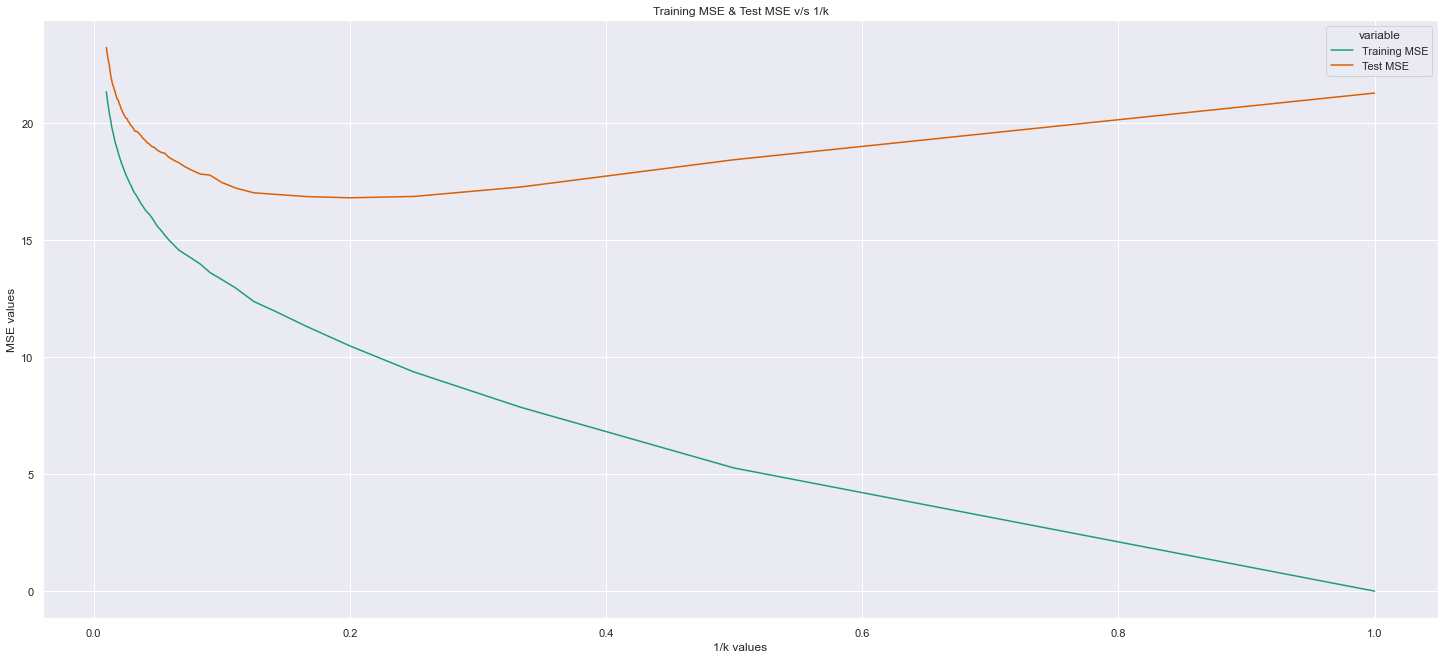

In [20]:
kval = list(range(1,101))
train_mse = []
test_mse = []
one_over_k = []
best_train_k = 0
best_test_k = 0
best_train_mse = math.inf
best_test_mse = math.inf
for k in kval:
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train,y_train)
    y_tr_predict = knn.predict(x_train)
    y_te_predict = knn.predict(x_test)
    tr_mse = mean_squared_error(y_train,y_tr_predict)
    te_mse = mean_squared_error(y_test,y_te_predict)
    if tr_mse < best_train_mse:
        best_train_k = k
        best_train_mse = tr_mse
    if te_mse < best_test_mse:
        best_test_k = k
        best_test_mse = te_mse
    one_over_k.append(1/k)
    train_mse.append(tr_mse)
    test_mse.append(te_mse)
    
print(f'Best k value for training dataset: {best_train_k}')
print(f'Best MSE value for training dataset: {best_train_mse}\n')
print(f'Best k value for test dataset: {best_test_k}')
print(f'Best MSE value for test dataset: {best_test_mse}\n')
print("Line Plot:")
print("---------")

error_dataframe = pd.DataFrame({'1/k':one_over_k,
                    'Training MSE': train_mse,
                    'Test MSE': test_mse})
seaborn.set(rc={'figure.figsize':(25,11)})
lplot = seaborn.lineplot(x="1/k",y="value",hue="variable",data=pd.melt(error_dataframe,['1/k']),palette="Dark2")
lplot.set(xlabel="1/k values",ylabel="MSE values",title="Training MSE & Test MSE v/s 1/k")
plt.show()

#### Normalized dataset

In [21]:
x_train_normalized = preprocessing.scale(x_train)
x_test_normalized = preprocessing.scale(x_test)

Best k value for training dataset: 1
Best MSE value for training dataset: 0.0

Best k value for test dataset: 6
Best MSE value for test dataset: 16.05989857869887

Line Plot:
---------


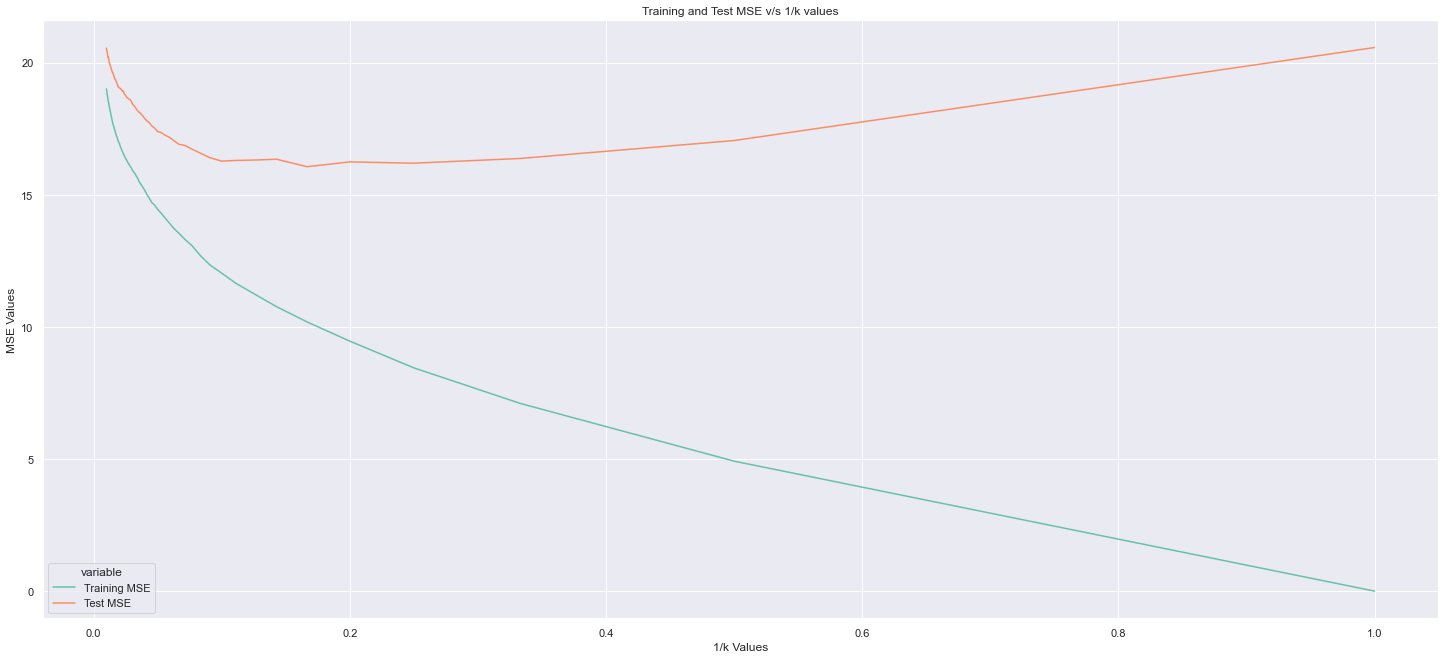

In [22]:
kval = list(range(1,101))
one_over_k = []
best_tr_k_norm = 0
best_tr_mse_norm = math.inf
best_te_k_norm = 0
best_te_mse_norm = math.inf
norm_train_mse = []
norm_test_mse = []
for k in kval:
    knn_norm = neighbors.KNeighborsRegressor(n_neighbors=k)
    knn_norm.fit(x_train_normalized,y_train)
    y_tr_norm_pred = knn_norm.predict(x_train_normalized)
    train_mse = mean_squared_error(y_train,y_tr_norm_pred)
    norm_train_mse.append(train_mse)
    y_te_norm_pred = knn_norm.predict(x_test_normalized)
    test_mse = mean_squared_error(y_test,y_te_norm_pred)
    norm_test_mse.append(test_mse)
    if train_mse < best_tr_mse_norm:
        best_tr_k_norm = k
        best_tr_mse_norm = train_mse
    if test_mse < best_te_mse_norm:
        best_te_k_norm = k
        best_te_mse_norm = test_mse
    one_over_k.append(1/k)
    
print(f'Best k value for training dataset: {best_tr_k_norm}')
print(f'Best MSE value for training dataset: {best_tr_mse_norm}\n')
print(f'Best k value for test dataset: {best_te_k_norm}')
print(f'Best MSE value for test dataset: {best_te_mse_norm}\n')
print("Line Plot:")
print("---------")

mse_dataframe = pd.DataFrame({"1/k":one_over_k,
                             "Training MSE": norm_train_mse,
                             "Test MSE": norm_test_mse})
seaborn.set(rc={'figure.figsize':(25,11)})
lplot = seaborn.lineplot(x="1/k",y="value",hue="variable",data=pd.melt(mse_dataframe,['1/k']),palette="Set2")
lplot.set(xlabel="1/k Values",ylabel="MSE Values",title="Training and Test MSE v/s 1/k values")
plt.show()

### (j ) Compare KNN and Linear

In [23]:
summary_data = [[training_mse,testing_mse],[all_tr_mse,all_te_mse],[rmv_tr_mse,rmv_te_mse],[best_train_mse,best_test_mse],[best_tr_mse_norm,best_te_mse_norm]]

In [24]:
summary = pd.DataFrame(summary_data,columns=['Training MSE','Test MSE'],index=['Linear Regression - All Predictors',
                                                                              'Linear Regression - All Interactions & Quadratics',
                                                                              'Linear Regression - Removing Insignificant Terms',
                                                                              'KNN Regression - Raw Dataset',
                                                                              'KNN Regression - Normalized Dataset'])

In [25]:
summary

,Training MSE,Test MSE
Linear Regression - All Predictors,20.549297,21.309501
Linear Regression - All Interactions & Quadratics,17.753368,19.009606
Linear Regression - Removing Insignificant Terms,17.821984,18.944387
KNN Regression - Raw Dataset,0.000000,16.819503
KNN Regression - Normalized Dataset,0.000000,16.059899


<font color="red">From the above table, we can conclude that KNN regression model works better than the Linear regression model with the smallest test error as well</font>

## 2. ISLR: 2.4.1

### (a) The sample size n is extremely large, and the number of predictors p is small.

As the sample size increase i.e the more observations are available and the number of predictors is small, flexible statistical model can better interpret the underlying data distributions than inflexible statistical model as it does not make any assumptions based on the features to fit the model. It draws its conclusions based on the dataset values themselves through analysis of the data distribution.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

As the number of predictors are large and the dataset size is small, flexible statistical model will not able to grasp the true distribution of the data as it follows noise too closely(overfitting). Hence, we can say that inflexible statistical models are more better here

### (c) The relationship between the predictors and response is highly non-linear.

Flexible statistical models adapt to the complexity of the data without making assumptions on the underlying data distributions and can handle non-linear/non-additive relationships. Hence, they would be better than inflexible statistical data model here.

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

Extremely high variance basically indicates that the data is very spread out and away from the mean and each other. In this case, flexible statistical models which already have low bias and high variance would suffer from overfitting. Hence, inflexible statistical models or learning methods (low variance and high bias) would perform better here.

## 3. ISLR: 2.4.7

In [26]:
exercise_df = pd.DataFrame([[0,3,0,"Red"],[2,0,0,"Red"],[0,1,3,"Red"],[0,1,2,"Green"],[-1,0,1,"Green"],[1,1,1,"Red"]],
                          columns=["X1","X2","X3","Y"], index=[1,2,3,4,5,6])
exercise_df

,X1,X2,X3,Y
1,0,3,0,Red
2,2,0,0,Red
3,0,1,3,Red
4,0,1,2,Green
5,-1,0,1,Green
6,1,1,1,Red


### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

In [27]:
def calculate_euclidean_distance(df,test_point):
    eucl = []
    for ind in df.index:
        eucl.append(((df['X1'][ind]-test_point[0])**2 + (df['X2'][ind]-test_point[1])**2 + (df['X3'][ind]-test_point[2])**2)**(1/2))
    df['Euclidean Distance'] = eucl
    return df
        
ex_df = calculate_euclidean_distance(exercise_df,[0,0,0])

In [28]:
ex_df

,X1,X2,X3,Y,Euclidean Distance
1,0,3,0,Red,3.000000
2,2,0,0,Red,2.000000
3,0,1,3,Red,3.162278
4,0,1,2,Green,2.236068
5,-1,0,1,Green,1.414214
6,1,1,1,Red,1.732051


### (b) What is our prediction with K = 1? Why?

when k = 1, we look to exactly 1 nearest neighbor. For the test point since x1,x2, and x3 = 0,the nearest euclidean distance would be 1.414(seen in the above table) which belongs to observation 5 which is <font color="green">GREEN</font>. Hence, we can say test point Y = <font color="green"><strong>GREEN</strong></font>.

### (c) What is our prediction with K = 3? Why?

when k = 3, we look to exactly 3 nearest neighbors.For the test point since x1,x2, and x3 = 0,the nearest euclidean distance would be 1.414,1.732 and 2 which are observations 5,6 and 2 and y values [<font color="green">GREEN</font>,<font color="red">RED</font>,<font color="red">RED</font>] respectively. Based on Majority polling in KNN we can say that the test point Y = <font color="red"><strong>RED</strong></font>.

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

Bayes decision boundary indicates a line/curve where the probability is exactly 50%. When this boundary is highly linear, it is better to fit the model flexibly using smaller k as larger k will overfit the model.

## Citations

1. https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/
2. https://www.theanalysisfactor.com/interactions-and-pairwise-comparisons/
3. https://www.statology.org/null-hypothesis-for-linear-regression/
4. https://medium.com/@faisalshahbaz/relationship-between-r-squared-and-p-value-in-a-regression-2378b1e2e9ce#:~:text=The%20greater%20R%2Dsquare%20the,model%20fits%20the%20data%20well
5. https://rpubs.com/cheeloonglian/342714